# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from tqdm import tqdm
import dask.dataframe as dd

mpl.style.use('default')
#%matplotlib notebook
%matplotlib inline

# Tensorflow backend initialization

In [2]:
"""
Setup multi GPU usage

Example usage:
model = Sequential()
...
multi_model = multi_gpu_model(model, gpus=num_gpu)
multi_model.fit()

About memory usage:
https://stackoverflow.com/questions/34199233/how-to-prevent-tensorflow-from-allocating-the-totality-of-a-gpu-memory
"""
import tensorflow as tf
from keras.utils.training_utils import multi_gpu_model
from tensorflow.python.client import device_lib

# IMPORTANT: Tells tf to not occupy a specific amount of memory
from keras.backend.tensorflow_backend import set_session  
config = tf.ConfigProto()  
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU  
sess = tf.Session(config=config)  
set_session(sess)  # set this TensorFlow session as the default session for Keras.


# getting the number of GPUs 
def get_available_gpus():
   local_device_protos = device_lib.list_local_devices()
   return [x.name for x in local_device_protos if x.device_type    == 'GPU']
num_gpu = len(get_available_gpus())
print('Amount of GPUs available: %s' % num_gpu)

/opt/jupyterhub/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


Amount of GPUs available: 4


# Function definitions

In [3]:
def create_corr_matrix(df, dwelling_id, annot):
    """
    Pearson correlation coefficient matrix. 
    The Pearson correlation coefficient is a measure of the linear correlation between two variables.
    """
    plt.clf()
    
    corr = df.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    if annot:
        fig, ax = plt.subplots(figsize=(25,25))
    else:
        fig, ax = plt.subplots()

    fig = sns.heatmap(corr, mask=mask, square=False, cmap='RdYlGn', annot=annot, ax=ax, 
                cbar_kws={'label':'Pearson correlation coefficient [-]'})

    fig.set_title('Correlation matrix of dwelling ID: '+dwelling_id)
    fig.tick_params(axis='x', rotation=90)
    fig.tick_params(axis='y', rotation=0)

    fig = fig.get_figure()
    fig.tight_layout()
    fig.show()
    
    print('Saving heatmap')
    #fig.savefig('//datc//opschaler//EDA//Pearson_corr//' + dwelling_id + '.png', dpi=300)
    return fig


def reduce_memory(df):
    """
    Reduces memory footprint of the input dataframe.
    Changes float64 columns to float32 dtype.
    """
    columns = df.columns
    memory_before = df.memory_usage(deep=False).sum() / 2**30 # convert bytes to GB

    for column in tqdm(columns):
        if df[column].dtype == 'float64':
            df[column] = df[column].astype('float32')
        
    memory_after = df.memory_usage(deep=False).sum() / 2**30 # convert bytes to GB
    print('Memory uasge reduced from %.3f GB to %.3f GB' % (memory_before, memory_after))
    
    return df


def resample_df(df, sample_rate):
    """
    Resampled a (un)processed dataframe to the specified sample_rate.
    Input is a (un)processed df.
    Sample rate must be a string. 
    For example '1H', '1D', '60s'.
    """
    
    input_df = df
    
    to_last = ['gasMeter', 'eMeter'] # resample.last(), take last known value from the columns
    
    input_df[to_last] = input_df[to_last].resample(sample_rate).last() # take last value most nearby the sample_rate
    
    input_df = input_df.resample(sample_rate).mean() # resample to rest by mean
    
    return input_df

# Preparing dataframe for preprocessing

In [4]:
%%time
df = pd.read_csv('//datc//opschaler//combined_gas_smart_weather_dfs//processed//P01S01W0998_hour.csv', delimiter='\t', parse_dates=['datetime'])
df = df.set_index(['datetime'])
df = df.drop(['dwelling'], axis=1)
df = df.dropna()

# Get an hour dataframe
h = resample_df(df, 'D') # For some reason this makes df equal h, so it changes the df variable being read in at the start...
h['hour'] = h.index.hour #create column containing the hour
h['dayofweek'] = h.index.dayofweek

CPU times: user 110 ms, sys: 2.06 ms, total: 113 ms
Wall time: 103 ms


In [5]:
h.head()

,eMeter,eMeterReturn,eMeterLow,eMeterLowReturn,ePower,ePowerReturn,gasMeter,DD,DR,FF,...,SQ,T,T10,TD,U,VV,WW,gasPower,hour,dayofweek
datetime,,,,,,,,,,,,,,,,,,,,,
2017-03-07,NaN,0.0,1872.332937,0.0,652.051355,0.0,NaN,277.578128,6.375000,3.766875,...,1.990461,7.301042,7.293750,4.942708,84.708333,20436.354125,6.072917,0.397808,0,1
2017-03-08,2422.496,0.0,1874.217143,0.0,522.781403,0.0,1031.054,205.302460,256.571429,5.246079,...,0.000000,6.624206,5.953572,5.374444,91.247619,11609.206224,30.642857,0.299096,0,2
2017-03-09,NaN,0.0,1876.489889,0.0,529.988832,0.0,NaN,243.497684,51.000000,4.514657,...,1.821256,7.871111,7.078333,6.398889,90.720370,9987.508303,22.151852,0.036614,0,3
2017-03-10,2442.635,0.0,1878.641045,0.0,425.238422,0.0,1037.883,197.589015,0.000000,2.264932,...,3.442213,5.827651,3.990455,2.470985,80.762879,16566.712118,10.036364,0.216048,0,4
2017-03-11,2442.635,0.0,1886.617292,0.0,738.780747,0.0,1039.810,128.449862,0.000000,2.373917,...,1.117497,8.258403,6.653681,3.016389,69.589583,24022.708250,1.887500,0.080292,0,5


## Get a proper hourly dataframe

Saving heatmap


/opt/jupyterhub/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


<Figure size 432x288 with 0 Axes>

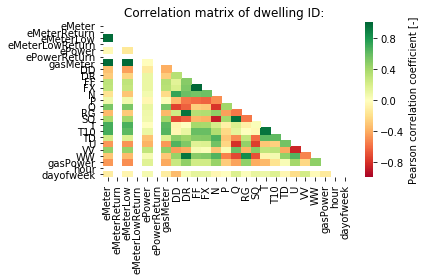

In [6]:
fig = create_corr_matrix(h, '', False)

## Select data we want

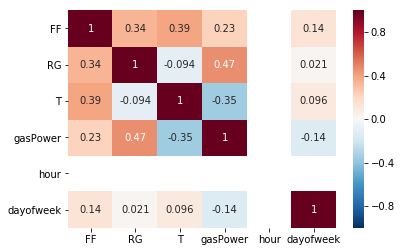

In [7]:
data = h
data = data.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter'], axis=1) # Not needed
data = data.drop(['WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX'], axis=1) # Drop weather columns which contain correlated information, keep only one type
#sns.heatmap(data.corr(), annot=True)

data = data.drop(['ePower', 'ePowerReturn'], axis=1) # Drop if want to predict gasPower

# Drop columns with that have a |corr| > 0.1 with T
data = data.drop(['U', 'N', 'Q', 'DD'], axis=1)

data = data[data['gasPower'] > 0] #filter data based on condition
data = data.dropna()
magnitude = 1
data['gasPower'] = data['gasPower']*10**magnitude

sns.heatmap(data.corr(), annot=True)

# EDA

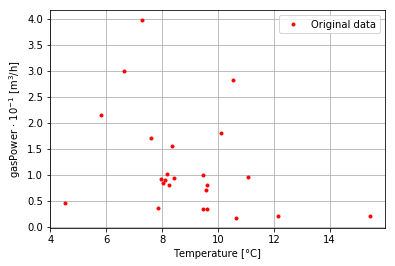

In [8]:
plt.plot(data['T'], data['gasPower'], '.', color='r', label='Original data')
plt.grid()
plt.xlabel('Temperature [°C]')
plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude)
plt.legend()

# Preprocessing

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

seed = 42

X = data.drop(['gasPower'], axis=1)
#X = data[['T']] # Only select T column
print('X columns final: %s' % list(X.columns))
#sns.heatmap(X.corr(), annot=True)

y = data[['gasPower']]

X columns final: ['FF', 'RG', 'T', 'hour', 'dayofweek']


# train_test_split the data

In [10]:
X = np.array(X).reshape(-1, len(X.columns))
y = np.array(y).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=seed)

# fit scalers to training data
scalerX = StandardScaler(with_mean=True, with_std=True).fit(X_train)
scalery = StandardScaler(with_mean=True, with_std=True).fit(y_train)

# Normalize X arrrays
X_train = scalerX.transform(X_train)
X_test = scalerX.transform(X_test)

# Get test data in the correct shape and format
y_train = np.array(y_train).reshape(-1,1) #reshape if y_train is not scaled, transforming should not be needed
y_test = np.array(y_test).reshape(-1,1)

def stats(ndarray):
    shape = ndarray.shape
    var = ndarray.var()
    mean = ndarray.mean()
    std = ndarray.std()
    min_ = ndarray.min()
    max_ = ndarray.max()
    return shape, var, mean, std, min_, max_

print('')
print('X_train -> \t shape: %s \t var: %.1f \t mean: %.1f \t std: %.1f, \t min: %.1f \t max: %.1f'% (stats(X_train)))
print('X_test -> \t shape: %s \t var: %.1f \t mean: %.1f \t std: %.1f, \t min: %.1f \t max: %.1f'% (stats(X_test)))
print('')
print('y_train -> \t shape: %s \t var: %.1E \t mean: %.1E  std: %.1E, \t min: %.1E \t max: %.1E'% (stats(y_train)))
print('y_test -> \t shape: %s \t var: %.1E \t mean: %.1E \t std: %.1E, \t min: %.1E \t max: %.1E'% (stats(y_test)))


X_train -> 	 shape: (12, 5) 	 var: 0.8 	 mean: -0.0 	 std: 0.9, 	 min: -1.6 	 max: 3.3
X_test -> 	 shape: (12, 5) 	 var: 38.2 	 mean: 1.4 	 std: 6.2, 	 min: -1.5 	 max: 39.3

y_train -> 	 shape: (12, 1) 	 var: 3.2E-01 	 mean: 9.6E-01  std: 5.7E-01, 	 min: 2.0E-01 	 max: 2.2E+00
y_test -> 	 shape: (12, 1) 	 var: 1.4E+00 	 mean: 1.4E+00 	 std: 1.2E+00, 	 min: 1.7E-01 	 max: 4.0E+00


# Predict gasPower with most other variables

# Create the model

In [11]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, MaxPool2D, Flatten, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import Adam, SGD, Nadam
from time import time
from livelossplot import PlotLossesKeras

In [73]:
%%time
# Create model
model = Sequential()


def generate_models(first_layer_sizes, deep_layers, deep_layer_sizes):
    models = []
        
    for deep_layer_size in deep_layer_sizes:
        print('deep_layer_size: %s' % deep_layer_size)
            
        for first_layer_size in first_layer_sizes:
            print('first_layer_size: %s' % first_layer_size)
            
            for layers in deep_layers:
                print('----layers, deep_layer_size: %s, %s' % (layers, deep_layer_size))
                model = Sequential()

                # Input layer
                model.add(Dense(first_layer_size, input_shape=(X_train.shape[1],), kernel_initializer='normal'))
                model.add(Activation('relu'))
                model.add(Dropout(0.5, seed=seed))

                for j in range(layers):
                    print('--------layer: %s' % j)
                    model.add(Dense(deep_layer_size, kernel_initializer='normal'))
                    model.add(Activation('relu'))
                    model.add(Dropout(0.5, seed=seed))
                    print('------------------------------------------------model finished')
        
                # Output layer
                model.add(Dense(1, kernel_initializer='normal'))
                model.add(Activation('linear'))
        
                # Compile model
                model = multi_gpu_model(model, gpus=num_gpu)
                model.compile(loss='mean_squared_error', metrics=['mse'], optimizer='adam')
                models.append(model)
                print('------------------------------------------------model compiled')
        
    return models


first_layer_sizes = [8, 16, 32, 64]
deep_layer_sizes = [8, 16, 32]
deep_layers = [0, 1, 2, 4, 8, 16]


models = generate_models(first_layer_sizes, deep_layers, deep_layer_sizes)

histories = []

for model in tqdm(models):
    tensorboard = TensorBoard(log_dir="/home/16011015/notebooks/logs/{}".format(time()))
    early_stopping_monitor = EarlyStopping(patience=10)
    
    history = model.fit(X_train, y_train, batch_size=int(len(X_train)), 
                epochs=100, verbose=3, validation_data=(X_test, y_test),
                callbacks=[early_stopping_monitor, PlotLossesKeras(), tensorboard])
    
    histories.append(history)

deep_layer_size: 8
first_layer_size: 8
----layers, deep_layer_size: 0, 8
----layers, deep_layer_size: 1, 8
--------layer: 0
------------------------------------------------model finished
----layers, deep_layer_size: 2, 8
--------layer: 0
------------------------------------------------model finished
--------layer: 1
------------------------------------------------model finished
----layers, deep_layer_size: 4, 8
--------layer: 0
------------------------------------------------model finished
--------layer: 1
------------------------------------------------model finished
--------layer: 2
------------------------------------------------model finished
--------layer: 3
------------------------------------------------model finished
----layers, deep_layer_size: 8, 8
--------layer: 0
------------------------------------------------model finished
--------layer: 1
------------------------------------------------model finished
--------layer: 2
------------------------------------------------model 

KeyboardInterrupt: 

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


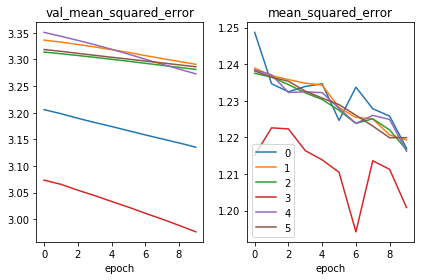

In [68]:
# Show results
for i, history in enumerate(histories):
    plt.subplot(1,2,1)
    plt.title('val_mean_squared_error')
    plt.plot(history.history['val_mean_squared_error'], label=i)
    plt.xlabel('epoch')
    plt.tight_layout()
    
    plt.subplot(1,2,2)
    plt.title('mean_squared_error')
    plt.plot(history.history['mean_squared_error'], label=i)
    plt.xlabel('epoch')
    plt.tight_layout()
    
    plt.legend()

In [71]:
models[3].summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_636_input (InputLayer)    (None, 5)            0                                            
__________________________________________________________________________________________________
lambda_181 (Lambda)             (None, 5)            0           dense_636_input[0][0]            
__________________________________________________________________________________________________
lambda_182 (Lambda)             (None, 5)            0           dense_636_input[0][0]            
__________________________________________________________________________________________________
lambda_183 (Lambda)             (None, 5)            0           dense_636_input[0][0]            
__________________________________________________________________________________________________
lambda_184

# Compile & fit

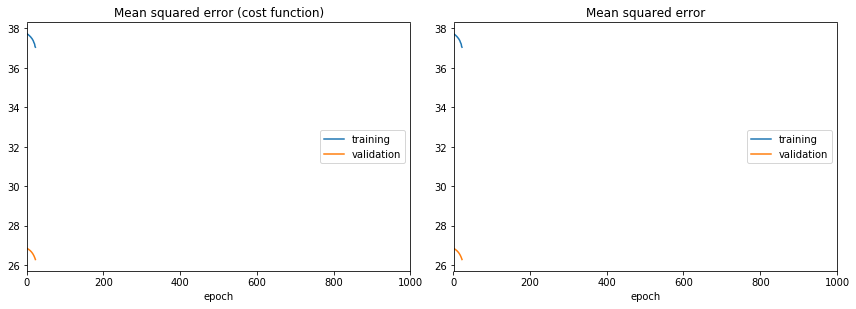

In [ ]:
%%time

# Compile and fit
multi_model = multi_gpu_model(model, gpus=num_gpu)

lr = 0.55
epochs = 1000
#decay_rate = 1*10**(-8)
decay_rate = 0
sgd = SGD(lr=lr, momentum=0.9, decay=decay_rate, nesterov=True) # sgd in general yields better results, but needs a lot of tweeking and is slower

# compiling the sequential model
#multi_model.compile(loss='mean_squared_error', optimizer='adam')
multi_model.compile(loss='mean_squared_error', metrics=['mse'], optimizer='adam')

early_stopping_monitor = EarlyStopping(patience=5000)

from livelossplot import PlotLossesKeras

tensorboard = TensorBoard(log_dir="/home/16011015/notebooks/logs/{}".format(time()))

# training the model and saving metrics in history
multi_model.fit(X_train, y_train, batch_size=int(len(X_train)), 
                epochs=epochs, verbose=2, validation_data=(X_test, y_test), 
                callbacks=[early_stopping_monitor, PlotLossesKeras(), tensorboard])

# Plot results

x_pred scaled-> 	 shape: (448, 5) 	 var: 9.8E-01 	 mean: 3.3E-02 	 std: 9.9E-01
x_pred inverse-> 	 shape: (448, 5) 	 var: 4.6E+01 	 mean: 6.9E+00 	 std: 6.8E+00
448/448 [==============================] - 0s 92us/step


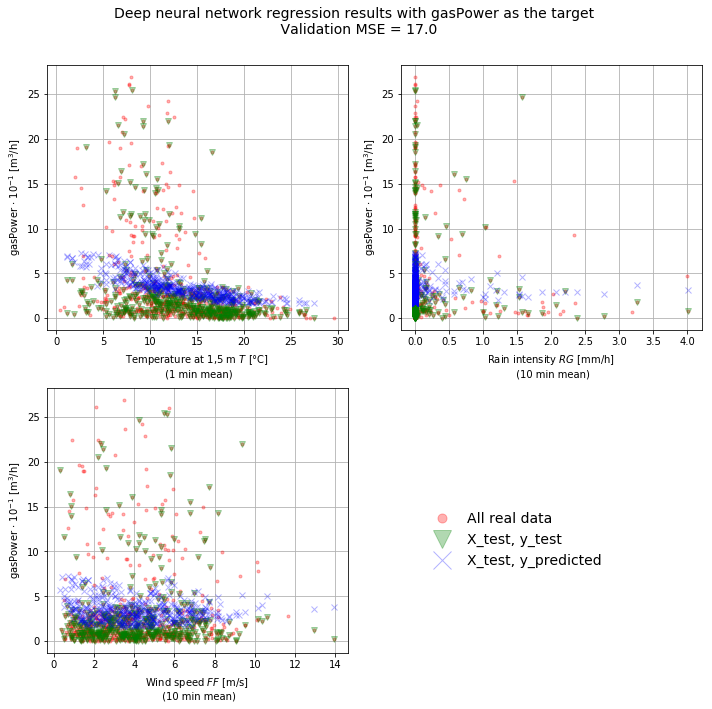

In [136]:
# X_test is already transformed
x_pred = X_test
#x_pred = scalerX.transform(x_pred)

y_pred = model.predict(x_pred)


print('x_pred scaled-> \t shape: %s \t var: %.1E \t mean: %.1E \t std: %.1E'% (x_pred.shape, x_pred.var(), x_pred.mean(), x_pred.std()))

x_pred = scalerX.inverse_transform(x_pred)
print('x_pred inverse-> \t shape: %s \t var: %.1E \t mean: %.1E \t std: %.1E'% (x_pred.shape, x_pred.var(), x_pred.mean(), x_pred.std()))

# select test variables
FF = x_pred[:,0]
RG = x_pred[:,1]
T = x_pred[:,2]

fig, axarr = plt.subplots(2,2)


axarr[0, 0].plot(data['T'], data['gasPower'], '.', color='r', alpha=0.3, label='Real')
axarr[0, 0].plot(T, y_test, 'v', color='g', label='X_test, y_test', alpha=0.3)
axarr[0, 0].plot(T, y_pred, 'x', color='b', label='Predicted', alpha=0.3)
axarr[0, 0].grid()
axarr[0, 0].set_xlabel('Temperature at 1,5 m $T$ [$\degree$C] \n (1 min mean)')
axarr[0, 0].set_ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude)

axarr[0, 1].plot(data['RG'], data['gasPower'], '.', color='r', alpha=0.3, label='Real')
axarr[0, 1].plot(RG, y_test, 'v', color='g', alpha=0.3, label='X_test, y_test')
axarr[0, 1].plot(RG, y_pred, 'x', color='b', alpha=0.3, label='Predicted')
axarr[0, 1].grid()
axarr[0, 1].set_xlabel('Rain intensity $RG$ [mm/h] \n (10 min mean)')
axarr[0, 1].set_ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude)


axarr[1, 0].plot(data['FF'], data['gasPower'], '.', color='r', alpha=0.3, label='All real data')
axarr[1, 0].plot(FF, y_test, 'v', color='g', label='X_test, y_test', alpha=0.3)
axarr[1, 0].plot(FF, y_pred, 'x', color='b', label='X_test, y_predicted', alpha=0.3)
axarr[1, 0].grid()
axarr[1, 0].set_xlabel('Wind speed $FF$ [m/s] \n (10 min mean)')
axarr[1, 0].set_ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude)

fig.delaxes(axarr[1, 1])

mse = multi_model.evaluate(X_test, y_test)[0]
mse_val = str(mse)[:4]
mse_power = str(mse)[-1:]

#fig.suptitle('Deep neural network regression results with gasPower as the target \n Validation MSE = %s $\cdot$ 10$^{-%s}$' % (mse_val, mse_power), fontsize = 14)
fig.suptitle('Deep neural network regression results with gasPower as the target \n Validation MSE = %s' % (mse_val), fontsize = 14)

fig.set_size_inches(10,10)
fig.tight_layout()

fig.subplots_adjust(top=0.9) # Adjust title spacing at the top

axarr[1, 0].legend(loc='lower left', bbox_to_anchor= (1.25, 0.3), borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

In [18]:
fig.savefig('DDN last result.png', dpi=1200)

In [19]:
# Complete plot, commented out
# X_test is already transformed
x_pred = X_test
#x_pred = scalerX.transform(x_pred)

y_pred = model.predict(x_pred)


print('x_pred scaled-> \t shape: %s \t var: %.1E \t mean: %.1E \t std: %.1E'% (x_pred.shape, x_pred.var(), x_pred.mean(), x_pred.std()))

x_pred = scalerX.inverse_transform(x_pred)
print('x_pred inverse-> \t shape: %s \t var: %.1E \t mean: %.1E \t std: %.1E'% (x_pred.shape, x_pred.var(), x_pred.mean(), x_pred.std()))

# select test variables
DD = x_pred[:,0]
FF = x_pred[:,1]
N = x_pred[:,2]
Q = x_pred[:,3]
RG = x_pred[:,4]
T = x_pred[:,5]
U = x_pred[:,6]

fig, axarr = plt.subplots(3,3)

axarr[0, 0].plot(data['DD'], data['gasPower'], '.', color='r', alpha=0.3, label='All real data')
axarr[0, 0].plot(DD, y_test, 'v', color='g', label='X_test, y_test', alpha=0.3)
axarr[0, 0].plot(DD, y_pred, 'x', color='b', label='X_test, y_predict', alpha=0.3)
axarr[0, 0].grid()
axarr[0, 0].set_xlabel('Wind direction $DD$ [$\degree$] \n (10 min mean)')
axarr[0, 0].set_ylabel(r'gasPower $\cdot$ 10$^{-2}$ [m$^3$/h]')

axarr[0, 1].plot(data['N'], data['gasPower'], '.', color='r', alpha=0.3, label='Real')
axarr[0, 1].plot(N, y_test, 'v', color='g', label='X_test, y_test', alpha=0.3)
axarr[0, 1].plot(N, y_pred, 'x', color='b', label='Predicted', alpha=0.3)
axarr[0, 1].grid()
axarr[0, 1].set_xlabel('Total cloud coverage $N$ [octa]')
axarr[0, 1].set_ylabel(r'gasPower $\cdot$ 10$^{-2}$ [m$^3$/h]')

axarr[0, 2].plot(data['Q'], data['gasPower'], '.', color='r', alpha=0.3, label='Real')
axarr[0, 2].plot(Q, y_test, 'v', color='g', label='X_test, y_test', alpha=0.3)
axarr[0, 2].plot(Q, y_pred, 'x', color='b', label='Predicted', alpha=0.3)
axarr[0, 2].grid()
axarr[0, 2].set_xlabel('global radiation $Q$ [W/m$^2$] \n (10 min mean)')
axarr[0, 2].set_ylabel(r'gasPower $\cdot$ 10$^{-2}$ [m$^3$/h]')

axarr[1, 0].plot(data['RG'], data['gasPower'], '.', color='r', alpha=0.3, label='Real')
axarr[1, 0].plot(RG, y_test, 'v', color='g', label='X_test, y_test', alpha=0.3)
axarr[1, 0].plot(RG, y_pred, 'x', color='b', label='Predicted', alpha=0.3)
axarr[1, 0].grid()
axarr[1, 0].set_xlabel('Rain intensity $RG$ [mm/h] \n (10 min mean)')
axarr[1, 0].set_ylabel(r'gasPower $\cdot$ 10$^{-2}$ [m$^3$/h]')

axarr[1, 1].plot(data['T'], data['gasPower'], '.', color='r', alpha=0.3, label='Real')
axarr[1, 1].plot(T, y_test, 'v', color='g', alpha=0.3, label='X_test, y_test')
axarr[1, 1].plot(T, y_pred, 'x', color='b', alpha=0.3, label='Predicted')
axarr[1, 1].grid()
axarr[1, 1].set_xlabel('Temperature at 1,5 m $T$ [$\degree$C] \n (1 min mean)')
axarr[1, 1].set_ylabel(r'gasPower $\cdot$ 10$^{-2}$ [m$^3$/h]')

axarr[1, 2].plot(data['U'], data['gasPower'], '.', color='r', alpha=0.3, label='Real')
axarr[1, 2].plot(U, y_test, 'v', color='g', label='X_test, y_test', alpha=0.3)
axarr[1, 2].plot(U, y_pred, 'x', color='b', label='Predicted', alpha=0.3)
axarr[1, 2].grid()
axarr[1, 2].set_xlabel('Relative humidity at 1,5 m $U$ [%] \n (1 min mean)')
axarr[1, 2].set_ylabel(r'gasPower $\cdot$ 10$^{-2}$ [m$^3$/h]')

axarr[2, 0].plot(data['FF'], data['gasPower'], '.', color='r', alpha=0.3, label='All real data')
axarr[2, 0].plot(FF, y_test, 'v', color='g', label='X_test, y_test', alpha=0.3)
axarr[2, 0].plot(FF, y_pred, 'x', color='b', label='X_test, y_predicted', alpha=0.3)
axarr[2, 0].grid()
axarr[2, 0].set_xlabel('Wind speed $FF$ [m/s] \n (10 min mean)')
axarr[2, 0].set_ylabel(r'gasPower $\cdot$ 10$^{-2}$ [m$^3$/h]')

fig.delaxes(axarr[2, 1])
fig.delaxes(axarr[2, 2])

mse = multi_model.evaluate(X_test, y_test)[0]
mse_val = str(mse)[:4]
mse_power = str(mse)[-1:]

fig.suptitle('Deep neural network regression results with gasPower as the target \n Validation MSE = %s' % (mse_val), fontsize = 14)

fig.set_size_inches(10,10)
fig.tight_layout()



fig.subplots_adjust(top=0.9) # Adjust title spacing at the top

axarr[2, 0].legend(loc='lower left', bbox_to_anchor= (2, 0.3), borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

x_pred scaled-> 	 shape: (448, 4) 	 var: 9.8E-01 	 mean: 6.2E-02 	 std: 9.9E-01
x_pred inverse-> 	 shape: (448, 4) 	 var: 5.2E+01 	 mean: 7.9E+00 	 std: 7.2E+00


IndexError: index 4 is out of bounds for axis 1 with size 4

In [ ]:
fig.savefig('DDN last result.png', dpi=1200)